# Estimate substitution rate for natural populations

Estimate the number of amino acid substitutions per year for simulated populations.

In [1]:
from augur.types import ValidationMode
from augur.utils import annotate_parents_for_tree, read_node_data, read_tree
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns

In [2]:
tree = read_tree("analysis/natural_substitution_rate/2019-10-01/tree.nwk")

In [3]:
tree = annotate_parents_for_tree(tree)

In [4]:
node_data = read_node_data(
    [
        "analysis/natural_substitution_rate/2019-10-01/branch_lengths.json",
        "analysis/natural_substitution_rate/2019-10-01/aa_muts.json",
    ],
    validation_mode=ValidationMode.SKIP,
)

Validating schema of 'analysis/natural_substitution_rate/2019-10-01/aa_muts.json'...


In [5]:
len(node_data["nodes"])

19000

In [6]:
# Count cumulative mutations per node.
for node in tree.find_clades():
    node_aa_muts = sum(len(muts) for muts in node_data["nodes"][node.name]["aa_muts"].values())
    node.total_aa_muts = getattr(node.parent, "total_aa_muts", 0) + node_aa_muts if node.parent else node_aa_muts

In [7]:
# Get pairs of dates and cumulative mutations.
dates = []
total_aa_muts = []

for node in tree.find_clades():
    date = node_data["nodes"][node.name]["numdate"]
    if date > 2000:
        dates.append(date)
        total_aa_muts.append(node.total_aa_muts)

In [8]:
dates[:5]

[2008.950406119168,
 2008.9518878285648,
 2012.4303278688524,
 2008.968160835984,
 2009.010018408284]

In [9]:
total_aa_muts[:5]

[0, 0, 0, 0, 0]

In [10]:
# Fit linear regression to estimate cumulative AA mutations per year.
slope, intercept, rvalue, pvalue, stderr = linregress(dates, total_aa_muts)

In [11]:
slope

2.5926765488960735

In [12]:
intercept

-5216.592409156279

In [13]:
rvalue

0.9012251064671226

In [14]:
rvalue ** 2

0.8122066925266765

In [15]:
stderr

0.009044845886350928

In [16]:
x = np.linspace(min(dates), max(dates) + 1, 100)

In [17]:
y = slope * x + intercept

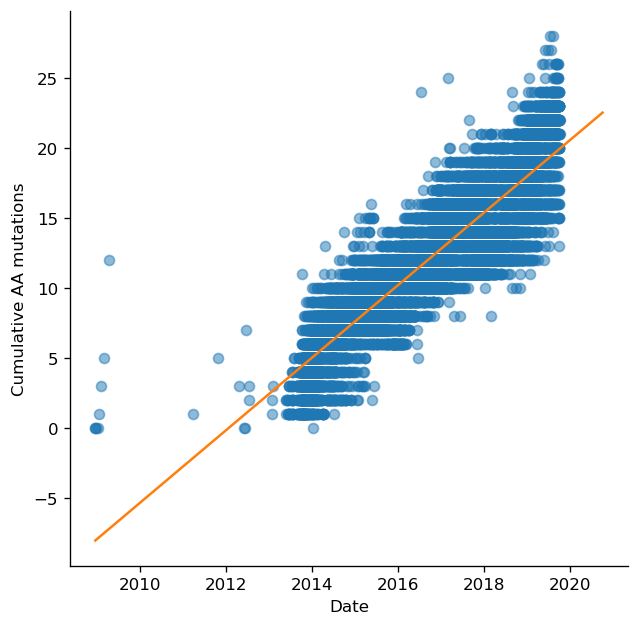

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
ax.plot(
    dates,
    total_aa_muts,
    "o",
    alpha=0.5,
)

ax.plot(
    x,
    y,
    color="C1",
)

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative AA mutations")
sns.despine()

In [19]:
df = pd.DataFrame({"date": dates, "total_aa_muts": total_aa_muts})

In [20]:
df.head()

,date,total_aa_muts
0,2008.950406,0
1,2008.951888,0
2,2012.430328,0
3,2008.968161,0
4,2009.010018,0


In [21]:
df["year"] = df["date"].astype(int)

In [29]:
range_of_total_aa_muts = np.diff(df.query("year > 2008").groupby("year").agg({"total_aa_muts": ["min", "max"]}))[:, 0]

In [30]:
df["year"].min()

2008

In [31]:
range_of_total_aa_muts

array([12,  4,  7, 10, 14, 14, 19, 17, 16, 17])

In [32]:
range_of_total_aa_muts.mean()

13.0

In [33]:
np.median(range_of_total_aa_muts)

14.0

In [34]:
range_of_total_aa_muts.min()

4

In [35]:
range_of_total_aa_muts.max()

19

<Axes: xlabel='year', ylabel='total_aa_muts'>

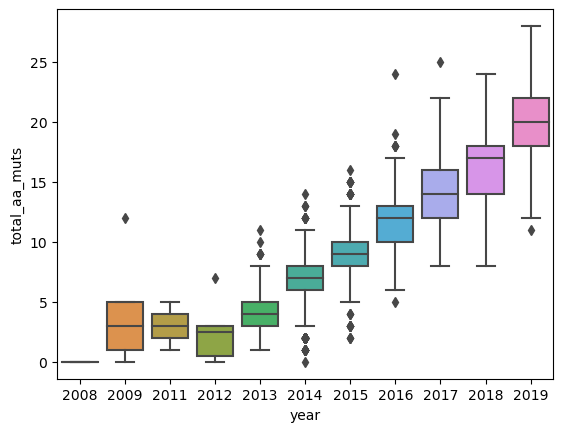

In [37]:
sns.boxplot(
    data=df,
    x="year",
    y="total_aa_muts",
)

In [47]:
aa_quantiles = df.groupby("year")["total_aa_muts"].quantile([0.25, 0.75]).reset_index().rename(columns={"level_1": "quantile"})

In [49]:
aa_quantiles.head()

,year,quantile,total_aa_muts
0,2008,0.25,0.0
1,2008,0.75,0.0
2,2009,0.25,1.0
3,2009,0.75,5.0
4,2011,0.25,2.0


In [54]:
aa_quantile_table = pd.pivot_table(
    aa_quantiles,
    values="total_aa_muts",
    columns="quantile",
    index="year",
).reset_index()

In [55]:
aa_quantile_table

quantile,year,0.25,0.75
0,2008,0.0,0.0
1,2009,1.0,5.0
2,2011,2.0,4.0
3,2012,0.5,3.0
4,2013,3.0,5.0
5,2014,6.0,8.0
6,2015,8.0,10.0
7,2016,10.0,13.0
8,2017,12.0,16.0
9,2018,14.0,18.0


In [58]:
(aa_quantile_table[0.75] - aa_quantile_table[0.25]).sort_values()

0     0.0
2     2.0
4     2.0
5     2.0
6     2.0
3     2.5
7     3.0
1     4.0
8     4.0
9     4.0
10    4.0
dtype: float64